<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
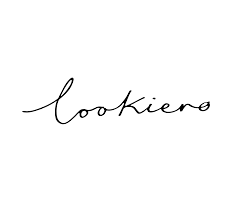    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Análisis inicial
En este script se detallarán los descriptivos obtenidos de este primer análisis. Tareas como detectar **cantidad de valores missing** o **outliers** entre otros.

### Carga de librerias 
---

- **General**

In [1]:
import pandas as pd
import numpy as np
import glob
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [3]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkFiles
from pyspark.sql import functions as F
from pyspark.sql.functions import lit

from pyspark.sql.functions import split
import pyspark.sql.functions as f
from pyspark.sql.functions import regexp_replace

- **Strings**

In [4]:
from collections import Counter
from pyspark.sql.functions import when
import re

### Clases a utilizar
---

* Clase para **cargar de datos** (cd)

Se fijan los **directorios** de entrada y salida

In [5]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

In [6]:
class carga_datos:
    ''' Cargar los datos desde el csv al python:
    - subir_tablas: se suben los dataframes con los titulos deseados. Como input: una lista de dfs y una lista de titulos.
    - subir_una_tabla: como input se especifica la tabla a subir.
    '''
    def __init__(self, dir_in = dir_in):
        self.dir_in = dir_in
        
    def subir_tablas(self, dir_in):
        path = os.getcwd()
        csv_files, dataframes_list = glob.glob(os.path.join(path, dir_in + "*.csv")), []

        for i in csv_files:
            temp_df = spark.read.csv(path = i, header = True, inferSchema = True)
            dataframes_list.append(temp_df)
        
        return dataframes_list
    
    def subir_una_tabla(self, dir_in, nombre_tabla):
        return pd.read_csv(os.path.join(dir_in, nombre_tabla + ".csv"))

In [7]:
cd = carga_datos ()

## Funciones a utilizar
---

- Función para **dar nombre** a la variable **family_id** mediante la variable title

In [8]:
def get_family_name(id_):
    
    filtered = product[product.family_id == id_]
    string = ' '.join(filtered.title).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

def get_family_name(id_):
    
    filtered = product.filter(product.family_id == id_)
    string = ' '.join([x['title'] for x in filtered.select('title').collect()]).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

____

In [9]:
dfs = cd.subir_tablas(dir_in)
titulos = os.listdir(dir_in)

In [10]:
size = cd.subir_una_tabla(dir_in, 'size')
size.to_csv(dir_out + 'size2.csv', sep = ';')
dfs[-1] = spark.read.csv(path = dir_out + 'size2.csv', header = True, inferSchema = True, sep = ';')

### Unión de *dataframes*

<center> 
<img  src="../imagenes/diagrama.PNG"> 


#### 1) df_total =  product variant + color + size + season

- **Season**: No utilizar
- **Size**: Utilizar solo la talla creada por *lookiero*
- **Color**: Utilizar solo el nombre del color

product_variant + size = 116 not used sizes NAN  
product_variant_size + color = 1 not used color (mixt) NAN

In [11]:
dfs[7].groupBy('channels').count().orderBy('count').show()
dfs[0].groupBy('number').count().orderBy('count').show()
dfs[3].groupBy('unit').count().orderBy('count').show()
dfs[-3].groupBy('season').count().orderBy('count').show()

+----------------+-----+
|        channels|count|
+----------------+-----+
|              []|  274|
|"[""LOOKIERO""]"| 2658|
+----------------+-----+

+------+-----+
|number|count|
+------+-----+
|     0|  163|
+------+-----+

+-----------+-----+
|       unit|count|
+-----------+-----+
| PERCENTAGE|    1|
|CENTIMETERS|    8|
|         \N|   52|
+-----------+-----+

+------+-----+
|season|count|
+------+-----+
|     9|20522|
|     7|22234|
|     8|22470|
+------+-----+



In [12]:
print(titulos)

['brand.csv', 'color.csv', 'datos_envios_MU.csv', 'desktop.ini', 'feature.csv', 'feature_qualifier.csv', 'feature_value.csv', 'feature_value_family.csv', 'product.csv', 'product_feature_value.csv', 'product_feature_value_qualifier.csv', 'product_variant.csv', 'season.csv', 'size.csv']


In [13]:
def rename_columns(df, suffix):
    ''' Renombra las columnas de un dataframe.'''
    for names in df.schema.names: df = df.withColumnRenamed(names,names + suffix)
    return df


* We rename the columnas to have a suffix when we join

In [14]:
dfs[-1] = rename_columns(dfs[-1], '_size')
dfs[1] = rename_columns(dfs[1], '_color')

* Se junta los 2 dataframes en uno solo.

In [15]:
df_total = dfs[10].join(dfs[-1].select('id_size','lookiero_size'), dfs[10].size_id == dfs[-1].id_size, "inner").drop('id_size', 'size_id')
df_total = df_total.join(dfs[1].select('id_color', 'name_color'), df_total.color_id == dfs[1].id_color).drop('id_color', 'color_id', 'legacy_id')
df_total = df_total.withColumnRenamed("lookiero_size","size_lookiero") \
    .withColumnRenamed("name_color","color")

* Se modifica la variable size_lookiero para que tenga formato numérico

In [16]:
df_total = df_total.withColumn('size_lookiero', split(df_total['size_lookiero'], ':').getItem(1))
df_total = df_total.withColumn('size_lookiero', regexp_replace('size_lookiero', '""', ''))
df_total = df_total.withColumn('size_lookiero', regexp_replace('size_lookiero', '}', ''))
df_total = df_total.withColumn('size_lookiero', split(df_total['size_lookiero'], ',').getItem(0))

In [17]:
print(df_total.collect()[0])

Row(id='e652ced0-571b-4ebe-a349-47155e190141', barcode=1281248, product_id='fa14ec83-b053-466e-afc0-ac164b77750f', season=9, stock=0, publishable='t', size_lookiero=' S', color='black')


#### 2) df_total += product

- **Product**: Dar nombre a la variable family_id y eliminar *legacy_id* y *channels*

product_variant + product = 41291 (63'3%) with no product_family or brand NAN  
NO SÉ SI SON COAT, SCARF O QUÉ...  
23935 SIN NAN

In [18]:
product = dfs[7].drop('legacy_id', 'channels')

unique_values_family =  [x['family_id'] for x in product.select('family_id').distinct().collect()]
parejas = dict(map(get_family_name, unique_values_family))
product = product.withColumn("product_family", product["family_id"])

# Este es el mapeado
for k, v in enumerate(unique_values_family): 
    product = product.withColumn('product_family', regexp_replace('product_family', v, str(parejas[v])))

# Se renombra la columna a la hora de unir
product = product.drop('family_id', 'title', '"""group"""')
product = rename_columns(product, '_product')

df_total = df_total.join(product, df_total.product_id == product.id_product).drop('product_id')

#### 3) df_total += brand

- **brand**: No utilizar variable number

df_total + brand = 0 NAN

In [19]:
brand = dfs[0].drop('number')
brand = brand.withColumnRenamed("id","id").withColumnRenamed("name","brand").withColumnRenamed("origin","brand_origin")
df_total = df_total.withColumn("publishable", when(df_total.publishable == "f",False).when(df_total.publishable == "t",True))
brand = rename_columns(brand, '_brand')
df_total = df_total.join(brand, df_total.brand_id_product == brand.id_brand).drop('brand_id_product','brand_id')

#### 4) values = feature values + feature (*value caracteristics*)

- **feature**: Multiple convertir en booleano (borrar??) y para poder eliminar la variable unit pasar los porcentajes a decimales (para diferenciarlos)

feature + feature_value = 1 value caracteristic not used NAN

In [20]:
feature = dfs[3]
feature = feature.withColumn("multiple", when(feature.multiple == "f",False).when(feature.multiple == "t",True))
column_names = ['id', 'feature_name', 'feature_type', 'feature_multiple', 'unit']

for k, v in enumerate(column_names):  feature = feature.withColumnRenamed(feature.schema.names[k], v)
feature_value = dfs[5]
feature = rename_columns(feature, '_values')
values = feature_value.join(feature, feature_value.feature_id == feature.id_values).drop('feature_id','id_values')

### **Hay que corregirlo pero no sé cómo**	

In [21]:
print((values.count(), len(values.columns)))


(2266, 6)


In [22]:
# from pyspark.sql.functions import monotonically_increasing_id 
# values = values.select("*").withColumn("index", monotonically_increasing_id())
# index = [x[0] for x in values.filter(values.unit_values == 'PERCENTAGE').select('index').collect()]

In [23]:
values.select('value').filter(values.unit_values == 'PERCENTAGE').withColumn('value', f.col('value')/100).collect()

[Row(value=0.25),
 Row(value=0.36),
 Row(value=0.93),
 Row(value=0.46),
 Row(value=0.87),
 Row(value=0.51),
 Row(value=0.72),
 Row(value=0.74),
 Row(value=0.26),
 Row(value=0.63),
 Row(value=0.44),
 Row(value=0.64),
 Row(value=0.17),
 Row(value=0.82),
 Row(value=0.42),
 Row(value=0.37),
 Row(value=0.12),
 Row(value=0.31),
 Row(value=0.08),
 Row(value=0.22),
 Row(value=0.59),
 Row(value=0.32),
 Row(value=0.11),
 Row(value=0.92),
 Row(value=0.41),
 Row(value=0.86),
 Row(value=0.24),
 Row(value=0.77),
 Row(value=0.03),
 Row(value=0.33),
 Row(value=0.02),
 Row(value=0.8),
 Row(value=0.45),
 Row(value=0.0),
 Row(value=0.29),
 Row(value=0.81),
 Row(value=0.3),
 Row(value=0.69),
 Row(value=0.75),
 Row(value=0.05),
 Row(value=0.2),
 Row(value=0.1),
 Row(value=0.52),
 Row(value=0.76),
 Row(value=0.66),
 Row(value=0.04),
 Row(value=1.0),
 Row(value=0.14),
 Row(value=0.53),
 Row(value=0.54),
 Row(value=0.28),
 Row(value=0.84),
 Row(value=0.67),
 Row(value=0.01),
 Row(value=0.6),
 Row(value=0.34),

feature_family no sirve para nada **creo** por lo que las siguientes celda en raw

#### 5) values + value family

In [24]:
for k, v in enumerate(['feature_family', 'feature_value_id']):  dfs[6] = dfs[6].withColumnRenamed(dfs[6].schema.names[k], v)
values = values.join(dfs[6], values.id == dfs[6].feature_value_id).drop('feature_value_id')


#### 6) product_values = values + product_feature_value

values + product_feature_value = 1420 (1'84%) caracteristics that has no product NAN

In [25]:
values = values.withColumnRenamed('id', 'id_values')
dfs[8] = dfs[8].withColumnRenamed('id', 'id_product_feature')
product_values = values.join(dfs[8], values.id_values == dfs[8].feature_value_id).drop('feature_value_id')

#### 7) product_values + df_total

products + features = 383 (0'06%) products without caracteristics NAN

In [26]:
df = df_total.join(product_values, df_total.id_product == product_values.product_id).drop('product_id')

id = Un único producto (se repite pork tiene diferentes features)  
id_product = El producto en general (niki manga larga)  
id_values = id de una característica
id_product_feature = id de la característica de un producto en general (id_product)

In [27]:
df.show(5)

+--------------------+-------+------+-----+-----------+-------------+-----+--------------------+----------------------+--------------------+-----------+------------------+--------------------+-----+-------------------+-------------------+-----------------------+-----------+--------------------+--------------------+
|                  id|barcode|season|stock|publishable|size_lookiero|color|          id_product|product_family_product|            id_brand|brand_brand|brand_origin_brand|           id_values|value|feature_name_values|feature_type_values|feature_multiple_values|unit_values|      feature_family|  id_product_feature|
+--------------------+-------+------+-----+-----------+-------------+-----+--------------------+----------------------+--------------------+-----------+------------------+--------------------+-----+-------------------+-------------------+-----------------------+-----------+--------------------+--------------------+
|498662e5-11e8-483...| 949392|     8|    0|      

### Gráficos
---

In [28]:
def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.2f%s' % (num, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])

paleta=['#264653','#2A9D8F','#85CAC2','#DFF6F4' ,'#E9C46A','#F4A261','#E76F51','#C53D1B', '#7E2711']

# Analisis de la variable season

In [30]:
season_all_color = df.groupBy('season' , "color").count().orderBy("count", ascending=False)

## SEASON_9

In [31]:
Season_9=season_all_color[season_all_color['season']==9]

In [32]:
orden=[]
orden1=[]
for a in Season_9.rdd.collect():
    orden.append(a.color)

for i in Season_9.rdd.collect():
    orden1.append(i['count'])

In [33]:
colores = paleta[1]
orden=orden[0:10]
fig = go.Figure(data=[go.Bar(x=orden, y=orden1,text=orden,textposition='auto',texttemplate = [human_format(a) for a in orden1], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Los colores que más se utilizan en 9',
    xaxis_title = 'Colores',
    yaxis_title = 'Cantidad',
    paper_bgcolor='white',
    plot_bgcolor='white')

## SEASON_8

In [34]:
Season_8=season_all_color[season_all_color['season']==8]

In [35]:
orden=[]
orden1=[]
for a in Season_8.rdd.collect():
    orden.append(a.color)

for i in Season_8.rdd.collect():
    orden1.append(i['count'])

In [36]:
colores = paleta[1]
orden=orden[0:10]
fig = go.Figure(data=[go.Bar(x=orden, y=orden1,text=orden,textposition='auto',texttemplate = [human_format(a) for a in orden1], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Los colores que más se utilizan en 8',
    xaxis_title = 'Colores',
    yaxis_title = 'Cantidad',
    paper_bgcolor='white',
    plot_bgcolor='white')

## SEASON_7

In [37]:
Season_7=season_all_color[season_all_color['season']==7]

In [38]:
orden=[]
orden1=[]
for a in Season_7.rdd.collect():
    orden.append(a.color)

for i in Season_7.rdd.collect():
    orden1.append(i['count'])

In [39]:
colores = paleta[1]
orden=orden[0:10]
fig = go.Figure(data=[go.Bar(x=orden, y=orden1,text=orden,textposition='auto',texttemplate = [human_format(a) for a in orden1], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Los colores que más se utilizan en 7',
    xaxis_title = 'Colores',
    yaxis_title = 'Cantidad',
    paper_bgcolor='white',
    plot_bgcolor='white')

# Productos que mas se consumen por cada estación

In [40]:
season_product = df.groupBy('season' , "product_family_product").count().orderBy("count", ascending=False)

## SEASON_9

In [41]:
Season_9=season_product[season_product['season']==9]

In [42]:
orden1=[]
orden = []
for a in Season_9.rdd.collect():
    orden.append(a.product_family_product)

for i in Season_9.rdd.collect():
    orden1.append(i['count'])

In [43]:
colores = paleta[1]
orden=orden[0:3]
fig = go.Figure(data=[go.Bar(x=orden, y=orden1,text=orden,textposition='auto',texttemplate = [human_format(a) for a in orden1], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Productos mas consumidos en la estación 9',
    xaxis_title = 'Productos',
    yaxis_title = 'Cantidad',
    paper_bgcolor='white',
    plot_bgcolor='white')

## SEASON_8

In [44]:
Season_8=season_product[season_product['season']==8]

In [45]:
orden1=[]
orden = []
for a in Season_8.rdd.collect():
    orden.append(a.product_family_product)

for i in Season_8.rdd.collect():
    orden1.append(i['count'])

In [46]:
colores = paleta[1]
orden=orden[0:3]
fig = go.Figure(data=[go.Bar(x=orden, y=orden1,text=orden,textposition='auto',texttemplate = [human_format(a) for a in orden1], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Productos mas consumidos en la estación 8',
    xaxis_title = 'Productos',
    yaxis_title = 'Cantidad',
    paper_bgcolor='white',
    plot_bgcolor='white')

## SEASON_7

In [47]:
Season_7=season_product[season_product['season']==7]

In [48]:
orden1=[]
orden = []
for a in Season_7.rdd.collect():
    orden.append(a.product_family_product)

for i in Season_7.rdd.collect():
    orden1.append(i['count'])

In [49]:
colores = paleta[1]
orden=orden[0:3]
fig = go.Figure(data=[go.Bar(x=orden, y=orden1,text=orden,textposition='auto',texttemplate = [human_format(a) for a in orden1], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Productos mas consumidos en la estación 7',
    xaxis_title = 'Productos',
    yaxis_title = 'Cantidad',
    paper_bgcolor='white',
    plot_bgcolor='white')

# MARCAS MAS USADAS Y SU ANALISIS

In [50]:
season_all_color = df.groupBy('brand_brand').count().orderBy("count", ascending=False)

In [164]:
orden = []
orden1= []
for a in season_all_color.rdd.collect():
    orden.append(a.brand_brand)
for i in season_all_color.rdd.collect():
    orden1.append(i['count'])

In [52]:
colores = paleta[1]
orden=orden[0:10]
fig = go.Figure(data=[go.Bar(x=orden, y=orden1,text=orden,textposition='auto',texttemplate = [human_format(a) for a in orden1], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Las 10 marcas mas usadas',
    xaxis_title = 'Marcas',
    yaxis_title = 'Cantidad',
    paper_bgcolor='white',
    plot_bgcolor='white')

In [53]:
brand_product= df.groupBy('brand_brand' , "product_family_product").count().orderBy("count", ascending=False)
brand_color= df.groupBy('brand_brand' , "color").count().orderBy("count", ascending=False)

## BRAND55

In [54]:
BRAND55_product=brand_product[brand_product['brand_brand']=='BRAND55']
BRAND55_color=brand_color[brand_color['brand_brand']=='BRAND55']

In [55]:
orden = []
orden1= []
orden2= []
orden3= []
for a in BRAND55_product.rdd.collect():
    orden.append(a['product_family_product'])
for i in BRAND55_product.rdd.collect():
    orden1.append(i['count'])
for e in BRAND55_color.rdd.collect():
    orden2.append(e['color'])
for j in BRAND55_color.rdd.collect():
    orden3.append(j['count'])

In [56]:
colores = paleta[1]
orden=orden[0:10]
fig = go.Figure(data=[go.Bar(x=orden, y=orden1,text=orden,textposition='auto',texttemplate = [human_format(a) for a in orden1], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Productos mas utilizados de la marca BRAND55',
    xaxis_title = 'Productos',
    yaxis_title = 'Cantidad',
    paper_bgcolor='white',
    plot_bgcolor='white')

In [57]:
colores = paleta[1]
orden2=orden2[0:10]
fig = go.Figure(data=[go.Bar(x=orden2, y=orden3,text=orden2,textposition='auto',texttemplate = [human_format(a) for a in orden3], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Colores más utilizados de la marca BRAND55',
    xaxis_title = 'Colores',
    yaxis_title = 'Cantidad',
    paper_bgcolor='white',
    plot_bgcolor='white')

## BRAND119

In [58]:
BRAND119_product=brand_product[brand_product['brand_brand']=='BRAND119']
BRAND119_color=brand_color[brand_color['brand_brand']=='BRAND119']

In [59]:
orden = []
orden1= []
orden2= []
orden3= []
for a in BRAND119_product.rdd.collect():
    orden.append(a['product_family_product'])
for i in BRAND119_product.rdd.collect():
    orden1.append(i['count'])
for e in BRAND119_color.rdd.collect():
    orden2.append(e['color'])
for j in BRAND119_color.rdd.collect():
    orden3.append(j['count'])

In [60]:
colores = paleta[1]
orden=orden[0:10]
fig = go.Figure(data=[go.Bar(x=orden, y=orden1,text=orden,textposition='auto',texttemplate = [human_format(a) for a in orden1], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Productos mas utilizados de la marca BRAND119',
    xaxis_title = 'Productos',
    yaxis_title = 'Cantidad',
    paper_bgcolor='white',
    plot_bgcolor='white')

In [61]:
colores = paleta[1]
orden2=orden2[0:10]
fig = go.Figure(data=[go.Bar(x=orden2, y=orden3,text=orden2,textposition='auto',texttemplate = [human_format(a) for a in orden3], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Colores más utilizados de la marca BRAND119',
    xaxis_title = 'Colores',
    yaxis_title = 'Cantidad',
    paper_bgcolor='white',
    plot_bgcolor='white')

## BRAND76

In [62]:
BRAND76_product=brand_product[brand_product['brand_brand']=='BRAND76']
BRAND76_color=brand_color[brand_color['brand_brand']=='BRAND76']

In [63]:
orden = []
orden1= []
orden2= []
orden3= []
for a in BRAND76_product.rdd.collect():
    orden.append(a['product_family_product'])
for i in BRAND76_product.rdd.collect():
    orden1.append(i['count'])
for e in BRAND76_color.rdd.collect():
    orden2.append(e['color'])
for j in BRAND76_color.rdd.collect():
    orden3.append(j['count'])

In [64]:
colores = paleta[1]
orden=orden[0:10]
fig = go.Figure(data=[go.Bar(x=orden, y=orden1,text=orden,textposition='auto',texttemplate = [human_format(a) for a in orden1], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Productos mas utilizados de la marca BRAND76',
    xaxis_title = 'Productos',
    yaxis_title = 'Cantidad',
    paper_bgcolor='white',
    plot_bgcolor='white')

In [65]:
colores = paleta[1]
orden2=orden2[0:10]
fig = go.Figure(data=[go.Bar(x=orden2, y=orden3,text=orden2,textposition='auto',texttemplate = [human_format(a) for a in orden3], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Colores más utilizados de la marca BRAND76',
    xaxis_title = 'Colores',
    yaxis_title = 'Cantidad',
    paper_bgcolor='white',
    plot_bgcolor='white')

In [134]:
color = df_total.select('color').collect()
color = np.array([x[0] for x in color])
Season = df_total.select('size_lookiero').collect()
Season = np.array([x[0] for x in Season])
df_heat = pd.DataFrame()
df_heat['size'], df_heat['product_family_product'] = Season, color

hm_131_p = pd.get_dummies(df_heat, columns=['product_family_product']).groupby(['size']).sum()
hm_131_p.columns = [x.replace('product_family_product', '').capitalize() for x in hm_131_p.columns]
hm_131_p=hm_131_p.loc[:,['_blue_dark','_white','_rust','_khaki','_ecru','_beige','_green_dark','_black','_mustand']]
hm_131_p=hm_131_p.iloc[0:3]

Text(0.5, 1, 'Relación entre Tallas y productos')

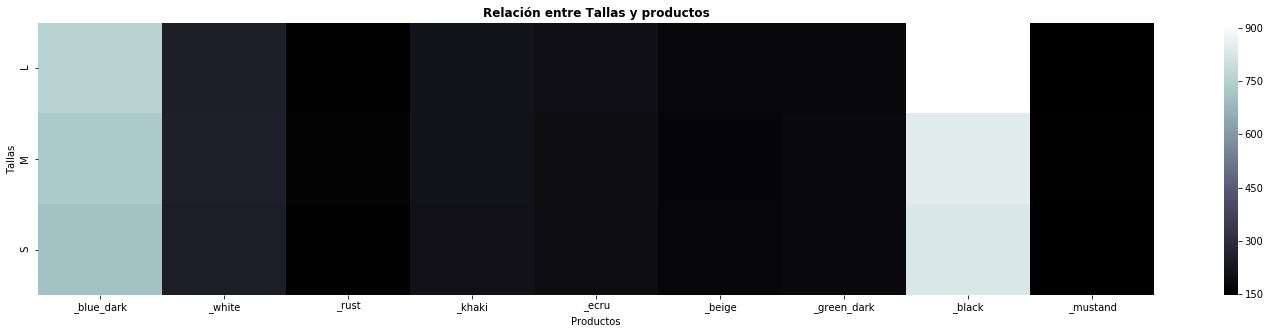

In [135]:
fig3, ax3 = plt.subplots(figsize = (25,5))
ax3 = sns.heatmap(hm_131_p,cmap='bone')
ax3.set_ylabel('Tallas')
ax3.set_xlabel('Productos')
ax3.set_title("Relación entre Tallas y productos",fontweight='bold')

In [155]:
color = df_total.select('color').collect()
color = np.array([x[0] for x in color])
Season = df_total.select('product_family_product').collect()
Season = np.array([x[0] for x in Season])
df_heat = pd.DataFrame()
df_heat['size'], df_heat['product_family_product'] = Season, color

hm_131_p = pd.get_dummies(df_heat, columns=['product_family_product']).groupby(['size']).sum()
hm_131_p.columns = [x.replace('product_family_product', '').capitalize() for x in hm_131_p.columns]
hm_131_p=hm_131_p.loc[:,['_blue_dark','_white','_rust','_khaki','_ecru','_beige','_green_dark','_black','_mustand']]
hm_131_p=hm_131_p.iloc[[13,-1,-3,7,4,10,5,-6]]

Text(0.5, 1, 'Relación entre Tallas y productos')

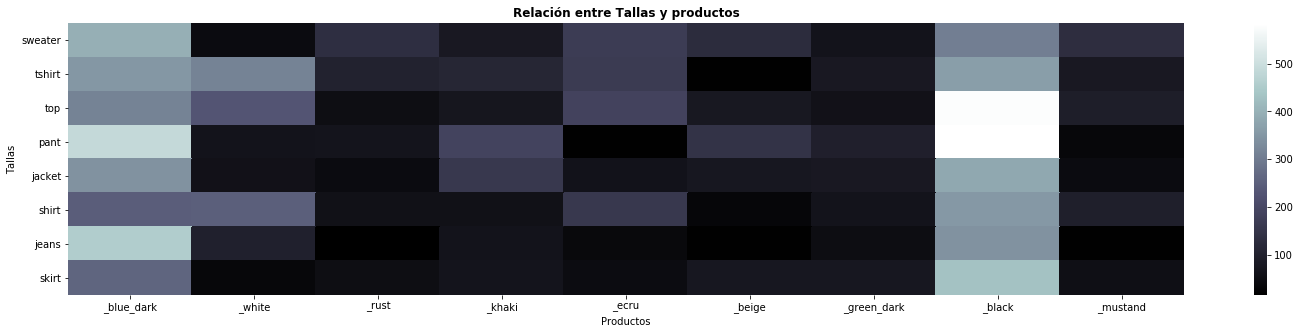

In [156]:
fig3, ax3 = plt.subplots(figsize = (25,5))
ax3 = sns.heatmap(hm_131_p,cmap='bone')
ax3.set_ylabel('Tallas')
ax3.set_xlabel('Productos')
ax3.set_title("Relación entre Tallas y productos",fontweight='bold')

In [180]:
color = df_total.select('brand_brand').collect()
color = np.array([x[0] for x in color])
Season = df_total.select('size_lookiero').collect()
Season = np.array([x[0] for x in Season])
df_heat = pd.DataFrame()
df_heat['size'], df_heat['product_family_product'] = Season, color

hm_131_p = pd.get_dummies(df_heat, columns=['product_family_product']).groupby(['size']).sum()
hm_131_p.columns = [x.replace('product_family_product', '').capitalize() for x in hm_131_p.columns]
hm_131_p=hm_131_p.loc[:,['_brand55','_brand119','_brand76','_brand89','_brand15','_brand102','_brand83','_brand142','_brand66']]
hm_131_p=hm_131_p.iloc[0:3]

Text(0.5, 1, 'Relación entre Tallas y productos')

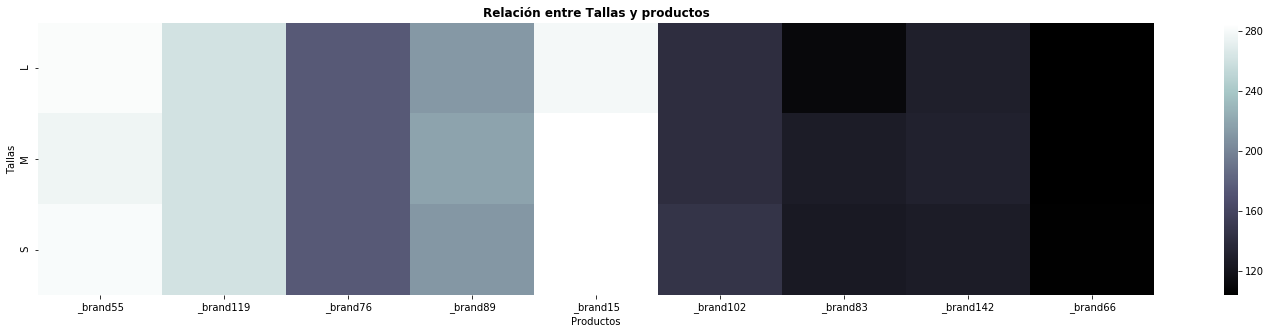

In [181]:
fig3, ax3 = plt.subplots(figsize = (25,5))
ax3 = sns.heatmap(hm_131_p,cmap='bone')
ax3.set_ylabel('Tallas')
ax3.set_xlabel('Productos')
ax3.set_title("Relación entre Tallas y productos",fontweight='bold')

## Araña

In [ ]:
df_concat1 = BRAND76_product.union(BRAND119_product)
df_producto = df_concat1.union(BRAND55_product)

In [ ]:
from math import pi

In [ ]:
categorias = [x["product_family_product"] for x in BRAND76_product.rdd.collect()]
pandasDF = df_producto.toPandas()

In [ ]:
table = pd.pivot_table(pandasDF, values='count', index=['brand_brand'],

                    columns=['product_family_product'], aggfunc=np.sum)

In [ ]:
df= table
# number of variable
categories=list(df)[1:]
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
# ax.set_rlabel_position(0)
# plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
# plt.ylim(0,40)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.reset_index(drop=True).values.flatten().tolist()[0:15]
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="BRAND76")
ax.fill(angles, values, 'b', alpha=0.1)

# Ind2
values=df.reset_index(drop=True).values.flatten().tolist()[16:31]
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="BRAND119")
ax.fill(angles, values, 'r', alpha=0.1)

# Ind3
values=df.reset_index(drop=True).values.flatten().tolist()[32:-1]
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="BRAND55")
ax.fill(angles, values, 'r', alpha=0.1)
 



# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()